**Importing libraries**


In [ ]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display


import torchaudio
import torch
from torch.utils.data import Dataset,DataLoader
from transformers import Wav2Vec2Model,Wav2Vec2Processor,Trainer,TrainingArguments,Wav2Vec2ForSequenceClassification

from IPython.display import Audio
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import os
import random
import kagglehub

paths = []
labels = []

dataset_path = kagglehub.dataset_download("ejlok1/toronto-emotional-speech-set-tess")

# Traverse dataset directory
for dirname, _, filenames in os.walk(dataset_path):
    for filename in filenames:
        if filename.endswith('.wav') and os.path.join(dirname, filename) not in paths:
            paths.append(os.path.join(dirname, filename))
            label = filename.split('_')[-1].split('.')[0].lower()
            labels.append(label)
        if len(paths) >= 2800:
            break

# Ensure exactly 2800 files are used
if len(paths) > 2800:
    sampled_paths = random.sample(paths, 2800)
    sampled_labels = [labels[paths.index(p)] for p in sampled_paths]
    paths, labels = sampled_paths, sampled_labels

print('Dataset is Loaded')
print(f"Number of audio files: {len(paths)}")  # Should be exactly 2800


100%|██████████| 428M/428M [00:04<00:00, 93.9MB/s]

Extracting files...


Dataset is Loaded
Number of audio files: 2800


In [ ]:
paths[:5]

['/root/.cache/kagglehub/datasets/ejlok1/toronto-emotional-speech-set-tess/versions/1/tess toronto emotional speech set data/TESS Toronto emotional speech set data/YAF_sad/YAF_tip_sad.wav',
 '/root/.cache/kagglehub/datasets/ejlok1/toronto-emotional-speech-set-tess/versions/1/tess toronto emotional speech set data/TESS Toronto emotional speech set data/OAF_Fear/OAF_knock_fear.wav',
 '/root/.cache/kagglehub/datasets/ejlok1/toronto-emotional-speech-set-tess/versions/1/tess toronto emotional speech set data/TESS Toronto emotional speech set data/OAF_disgust/OAF_ton_disgust.wav',
 '/root/.cache/kagglehub/datasets/ejlok1/toronto-emotional-speech-set-tess/versions/1/tess toronto emotional speech set data/TESS Toronto emotional speech set data/OAF_happy/OAF_keen_happy.wav',
 '/root/.cache/kagglehub/datasets/ejlok1/toronto-emotional-speech-set-tess/versions/1/tess toronto emotional speech set data/TESS Toronto emotional speech set data/YAF_fear/YAF_mill_fear.wav']

In [ ]:
labels

['sad',
 'fear',
 'disgust',
 'happy',
 'fear',
 'fear',
 'ps',
 'happy',
 'happy',
 'happy',
 'disgust',
 'sad',
 'sad',
 'ps',
 'sad',
 'happy',
 'sad',
 'disgust',
 'disgust',
 'disgust',
 'angry',
 'ps',
 'disgust',
 'ps',
 'neutral',
 'neutral',
 'sad',
 'disgust',
 'fear',
 'angry',
 'neutral',
 'angry',
 'disgust',
 'angry',
 'happy',
 'neutral',
 'sad',
 'neutral',
 'fear',
 'disgust',
 'neutral',
 'happy',
 'fear',
 'sad',
 'ps',
 'sad',
 'fear',
 'sad',
 'sad',
 'happy',
 'disgust',
 'fear',
 'neutral',
 'fear',
 'sad',
 'happy',
 'happy',
 'happy',
 'angry',
 'disgust',
 'neutral',
 'disgust',
 'sad',
 'angry',
 'fear',
 'sad',
 'happy',
 'happy',
 'fear',
 'sad',
 'fear',
 'fear',
 'neutral',
 'ps',
 'angry',
 'angry',
 'sad',
 'neutral',
 'angry',
 'sad',
 'happy',
 'angry',
 'happy',
 'disgust',
 'angry',
 'ps',
 'disgust',
 'neutral',
 'neutral',
 'happy',
 'ps',
 'fear',
 'ps',
 'ps',
 'sad',
 'angry',
 'fear',
 'happy',
 'ps',
 'happy',
 'angry',
 'angry',
 'ps',
 'ang

In [ ]:

len(paths)

2800

In [ ]:
paths[:5]

['/root/.cache/kagglehub/datasets/ejlok1/toronto-emotional-speech-set-tess/versions/1/tess toronto emotional speech set data/TESS Toronto emotional speech set data/YAF_sad/YAF_tip_sad.wav',
 '/root/.cache/kagglehub/datasets/ejlok1/toronto-emotional-speech-set-tess/versions/1/tess toronto emotional speech set data/TESS Toronto emotional speech set data/OAF_Fear/OAF_knock_fear.wav',
 '/root/.cache/kagglehub/datasets/ejlok1/toronto-emotional-speech-set-tess/versions/1/tess toronto emotional speech set data/TESS Toronto emotional speech set data/OAF_disgust/OAF_ton_disgust.wav',
 '/root/.cache/kagglehub/datasets/ejlok1/toronto-emotional-speech-set-tess/versions/1/tess toronto emotional speech set data/TESS Toronto emotional speech set data/OAF_happy/OAF_keen_happy.wav',
 '/root/.cache/kagglehub/datasets/ejlok1/toronto-emotional-speech-set-tess/versions/1/tess toronto emotional speech set data/TESS Toronto emotional speech set data/YAF_fear/YAF_mill_fear.wav']

In [ ]:

labels[:5]

In [ ]:

## Create a dataframe
df = pd.DataFrame()
df['audio_paths'] = paths
df['label'] = labels
df.head()

,audio_paths,label
0,/root/.cache/kagglehub/datasets/ejlok1/toronto...,sad
1,/root/.cache/kagglehub/datasets/ejlok1/toronto...,fear
2,/root/.cache/kagglehub/datasets/ejlok1/toronto...,disgust
3,/root/.cache/kagglehub/datasets/ejlok1/toronto...,happy
4,/root/.cache/kagglehub/datasets/ejlok1/toronto...,fear


In [ ]:

df['label'].value_counts()

,count
label,
disgust,402
ps,402
angry,402
sad,399
fear,399
happy,398
neutral,398


<Axes: xlabel='label', ylabel='count'>

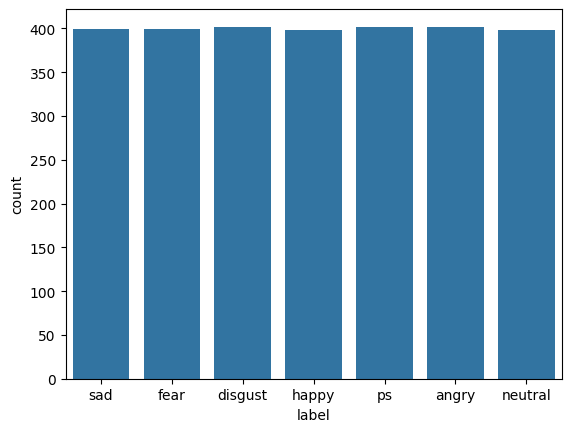

In [ ]:

sns.countplot(data=df, x='label')

In [ ]:
def waveplot(data, sr, emotion):
    plt.figure(figsize=(10,4))
    plt.title(emotion, size=20)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def spectogram(data, sr, emotion):
    x = librosa.stft(data)
    xdb = librosa.amplitude_to_db(abs(x))
    plt.figure(figsize=(11,4))
    plt.title(emotion, size=20)
    librosa.display.specshow(xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()

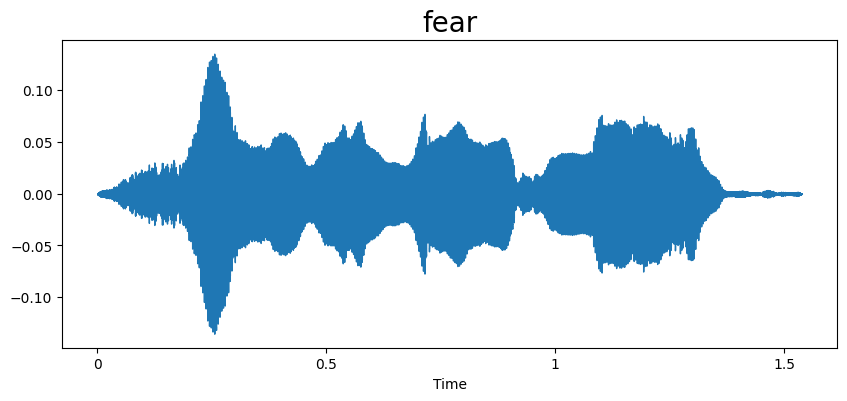

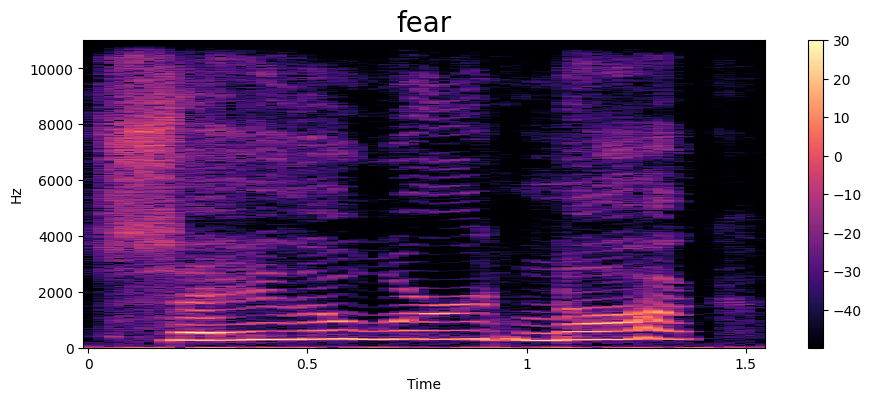

In [ ]:
emotion = 'fear'
path = np.array(df['audio_paths'][df['label']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

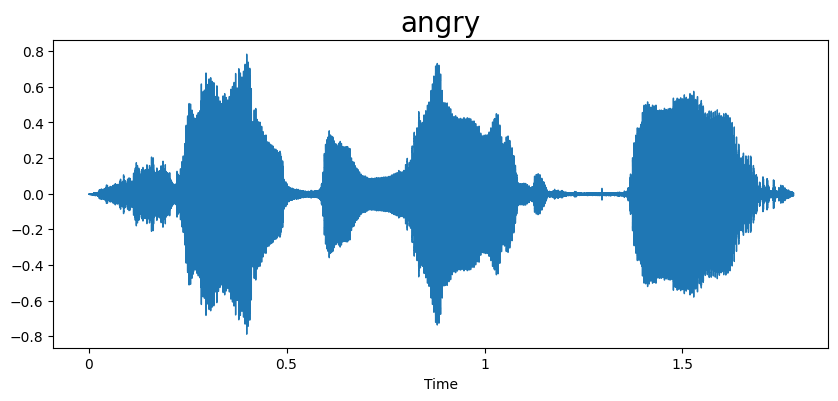

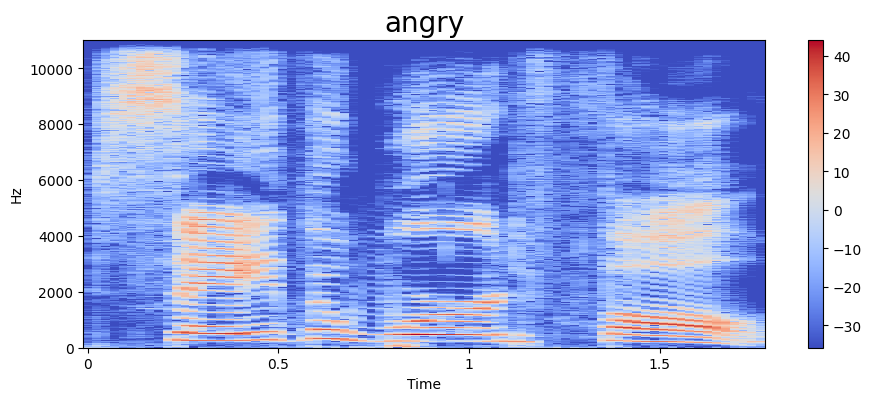

In [ ]:
emotion = 'angry'
path = np.array(df['audio_paths'][df['label']==emotion])[1]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

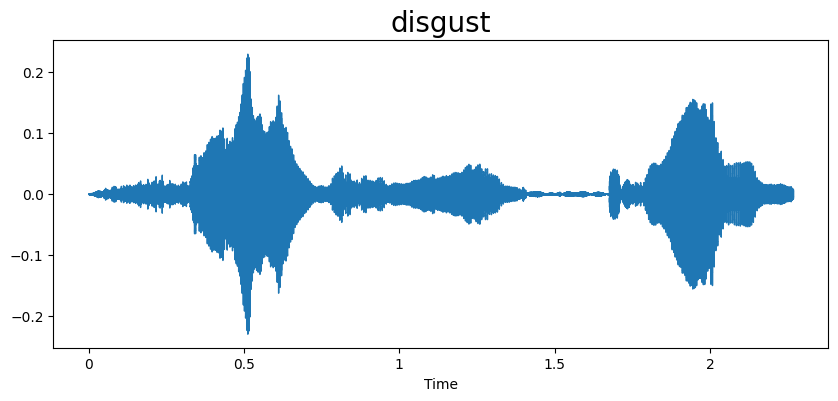

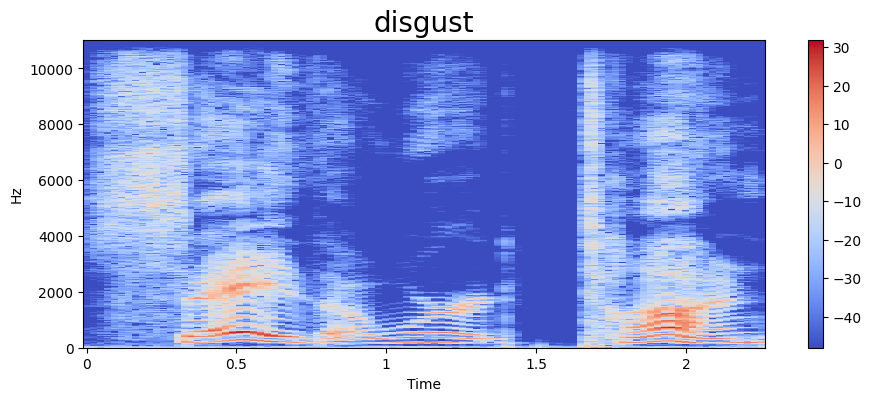

In [ ]:
emotion = 'disgust'
path = np.array(df['audio_paths'][df['label']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)


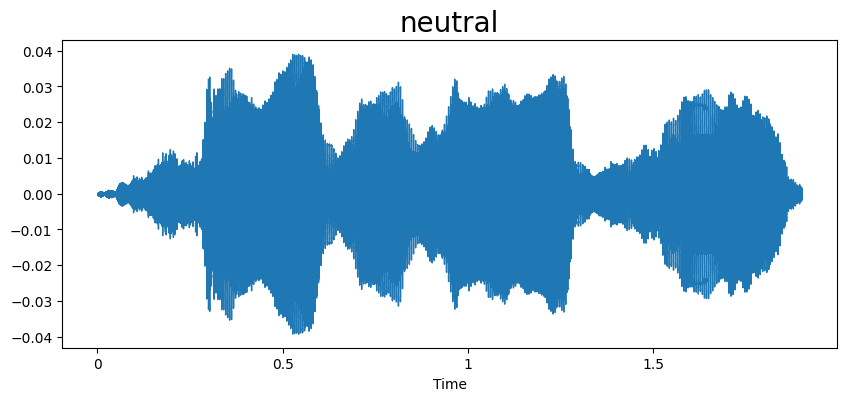

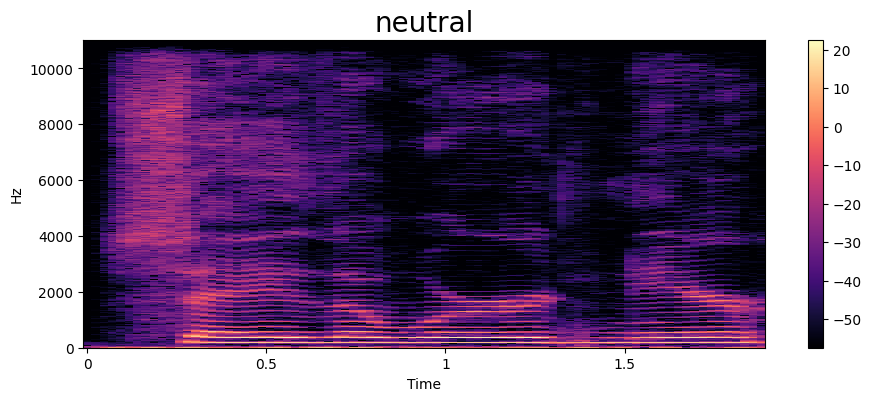

In [ ]:

emotion = 'neutral'
path = np.array(df['audio_paths'][df['label']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

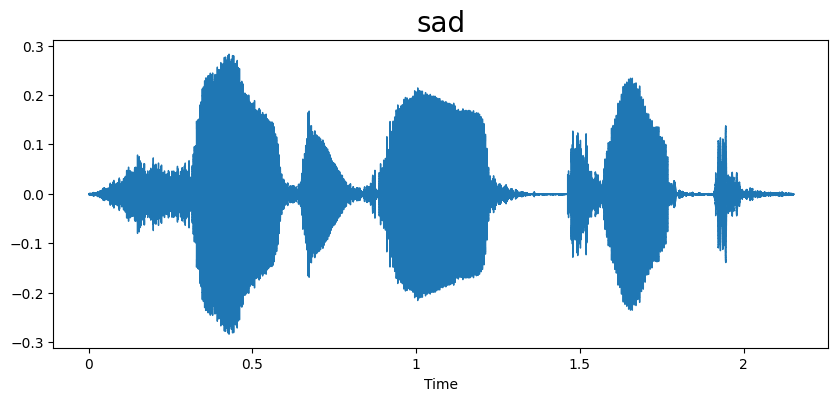

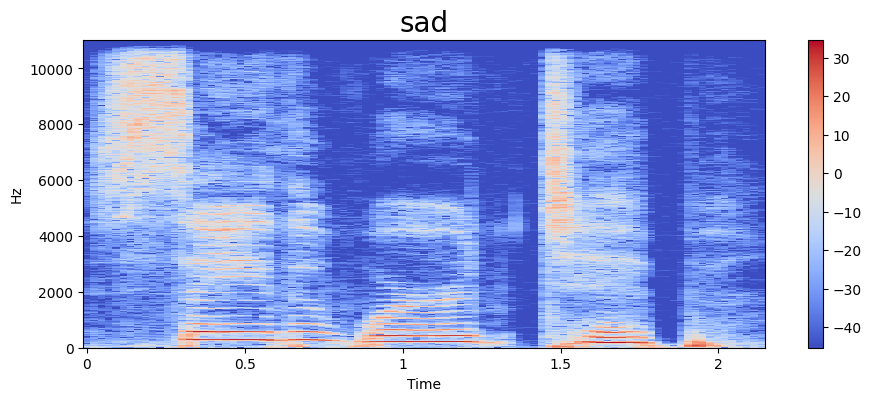

In [ ]:

emotion = 'sad'
path = np.array(df['audio_paths'][df['label']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

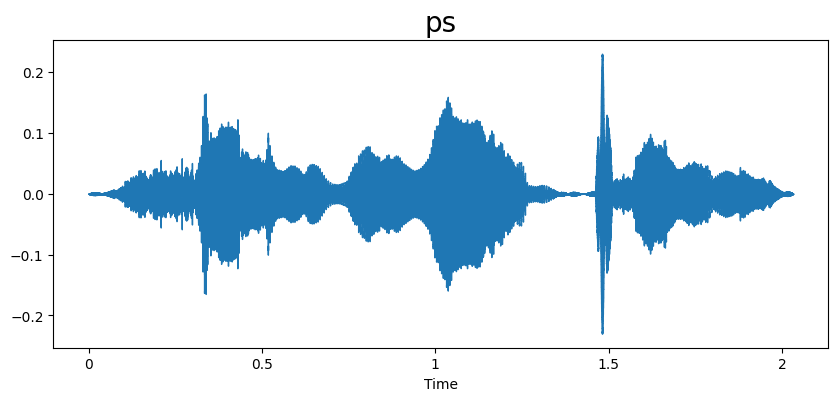

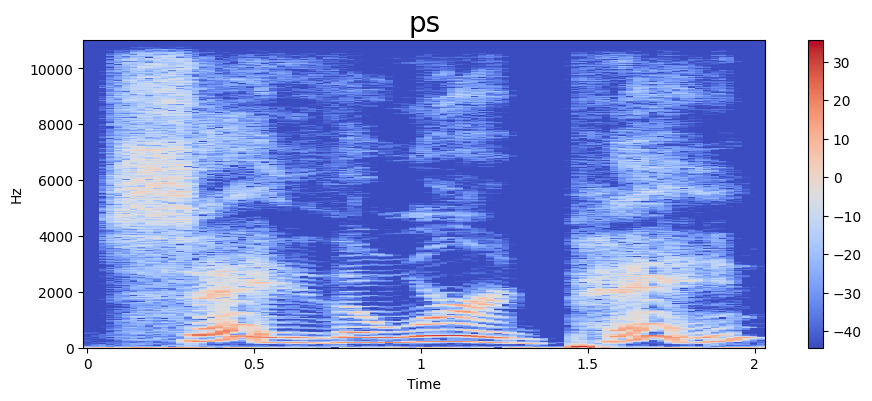

In [ ]:

emotion = 'ps'
path = np.array(df['audio_paths'][df['label']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

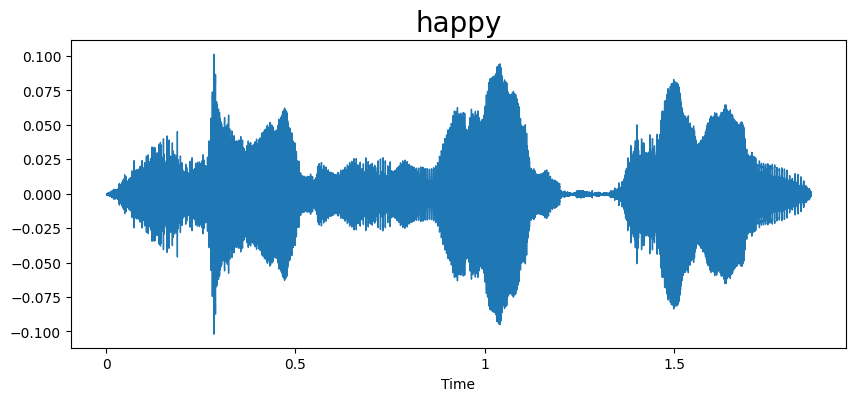

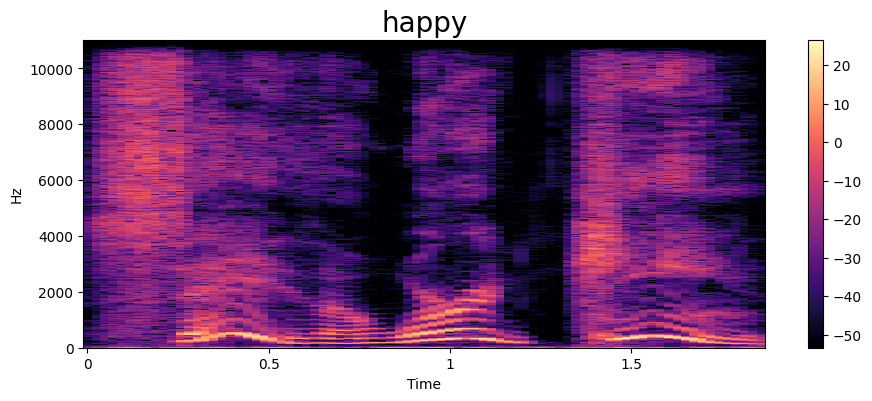

In [ ]:
emotion = 'happy'
path = np.array(df['audio_paths'][df['label']==emotion])[0]
data, sampling_rate = librosa.load(path)
len(data)
sampling_rate
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)


In [ ]:
# def extract_mfcc(filename):
#     y, sr = librosa.load(filename, duration=3, offset=0.5)
#     mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40).T, axis=0)
#     return mfcc

In [ ]:

# extract_mfcc(df['speech'][0])

In [ ]:

# extract_mfcc(df['speech'][0])

In [ ]:
# X_mfcc = df['speech'].apply(lambda x: extract_mfcc(x))
# X_mfcc

In [ ]:
# X = [x for x in X_mfcc]
# X = np.array(X)
# X.shape

In [ ]:
# ## input split
# X = np.expand_dims(X, -1)
# X.shape

In [ ]:
# from sklearn.preprocessing import OneHotEncoder
# enc = OneHotEncoder()
# y = enc.fit_transform(df[['label']])

In [ ]:
# y = y.toarray()

In [ ]:

# y.shape

In [ ]:
# from keras.models import Sequential
# from keras.layers import Dense, LSTM, Dropout

# model = Sequential([
#     LSTM(256, return_sequences=False, input_shape=(40,1)),
#     Dropout(0.2),
#     Dense(128, activation='relu'),
#     Dropout(0.2),
#     Dense(64, activation='relu'),
#     Dropout(0.2),
#     Dense(7, activation='softmax')
# ])

# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# model.summary()

In [ ]:
# history = model.fit(X, y, validation_split=0.2, epochs=70, batch_size=64)

In [ ]:
# from google.colab import files
# model.save('voice_model_hasi.h5')

# # Download the saved model
# files.download('voice_model_hasi.h5')

In [ ]:
# if hasattr(model, 'class_names'):
#     print("Class Names:", model.class_names)


In [ ]:
# import tensorflow as tf
# import numpy as np

# # Load the model
# model = tf.keras.models.load_model("voice_model_hasi.h5")

# # Print model summary to check the output layer
# model.summary()

# # Create a dummy input matching the model's input shape
# dummy_input = np.random.rand(1, 40, 162, 1)  # Adjust shape to match your model

# # Get predictions
# predictions = model.predict(dummy_input)

# # Print the predicted index
# predicted_index = np.argmax(predictions)
# print("Predicted Index:", predicted_index)

# # Check output shape
# print("Model Output Shape:", predictions.shape)


In [ ]:
# from google.colab import files
# model.save('voice_model_hasi.h5')

# # Download the saved model
# files.download('voice_model_hasi.h5')

In [ ]:
label_map={label:idx for idx,label in enumerate(df['label'].unique())}
inverse_lable_map={idx:label for label,idx in label_map.items()}
df['labels']=df['label'].map(label_map)
df.head()

,audio_paths,label,labels
0,/root/.cache/kagglehub/datasets/ejlok1/toronto...,sad,0
1,/root/.cache/kagglehub/datasets/ejlok1/toronto...,fear,1
2,/root/.cache/kagglehub/datasets/ejlok1/toronto...,disgust,2
3,/root/.cache/kagglehub/datasets/ejlok1/toronto...,happy,3
4,/root/.cache/kagglehub/datasets/ejlok1/toronto...,fear,1


In [ ]:
class SpeechEmotionDataset (Dataset):
    def __init__(self, df,processor,max_length=32000):
        self.df = df
        self.processor = processor
        self.max_length = max_length
    def __len__(self):
        return len(self.df)
    def __getitem__(self, index):
        audio_path=self.df.iloc[index]['audio_paths']
        label=self.df.iloc[index]['labels']

        speech,sr=librosa.load(audio_path,sr=16000)

        if len(speech)> self.max_length:
            speech=speech[:self.max_length]
        else:
            speech=np.pad(speech,(0,self.max_length-len(speech)),'constant')


        input=self.processor(speech,sampling_rate=16000,return_tensors='pt',padding=True,truncate=True,max_length=self.max_length)
        input_values=input.input_values.squeeze()
        return {'input_values':input_values,'labels':torch.tensor(label,dtype=torch.long)}


In [ ]:
from sklearn.model_selection import train_test_split
train_df,test_df=train_test_split(df,test_size=0.2,random_state=42)

In [ ]:

processor=Wav2Vec2Processor.from_pretrained('facebook/wav2vec2-base-960h')
model=Wav2Vec2ForSequenceClassification.from_pretrained('facebook/wav2vec2-base-960h',num_labels=7)

preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/163 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.60k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/378M [00:00<?, ?B/s]

Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight', 'wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
train_dataset=SpeechEmotionDataset(train_df,processor)
test_dataset=SpeechEmotionDataset(test_df,processor)
#

In [ ]:
train_dataloader=DataLoader(train_dataset,batch_size=8,shuffle=True)
test_dataloader=DataLoader(test_dataset,batch_size=8,shuffle=False)

In [ ]:
training_args=TrainingArguments(
    output_dir='./results',
    evaluation_strategy='epoch',
    save_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    report_to=[]

)

In [ ]:
from sklearn.metrics import accuracy_score,precision_recall_fscore_support
def compute_metrics(pred):
    labels=pred.label_ids
    # preds = pred.predictions.argmax(axis=1)
    preds = pred.predictions.argmax(axis=1)

    accuracy=accuracy_score(labels,preds)
    precision,recall,f1,_=precision_recall_fscore_support(labels,preds,average='weighted')
    return {
        'accuracy':accuracy,
        'precision':precision,
        'recall':recall,
        'f1':f1
    }

In [ ]:
trainer=Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.325416,0.992857,0.993182,0.992857,0.992854
2,No log,0.156400,1.000000,1.000000,1.000000,1.000000
3,No log,0.118922,1.000000,1.000000,1.000000,1.000000


TrainOutput(global_step=420, training_loss=0.4317571004231771, metrics={'train_runtime': 320.0038, 'train_samples_per_second': 21.0, 'train_steps_per_second': 1.312, 'total_flos': 1.2201848064e+17, 'train_loss': 0.4317571004231771, 'epoch': 3.0})

In [ ]:
train_dataset[0]['input_values'].size()

In [ ]:
model.save_pretrained("./saved_model")
processor.save_pretrained("./saved_model")


[]

In [ ]:
import shutil

# Assuming the model and processor were saved in './saved_model'
shutil.make_archive('saved_model', 'zip', './saved_model')


'/content/saved_model.zip'

In [ ]:
from google.colab import files

files.download('saved_model.zip')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
def preprocess_audio(audio_path, processor, max_length=32000):
    speech, sr = librosa.load(audio_path, sr=16000)  # Load audio at 16kHz

    # Truncate or pad the audio to the required length
    if len(speech) > max_length:
        speech = speech[:max_length]
    else:
        speech = np.pad(speech, (0, max_length - len(speech)), 'constant')

    # Process input
    input_data = processor(speech, sampling_rate=16000, return_tensors="pt", padding=True)
    return input_data.input_values


In [ ]:
import torchaudio
import librosa
import numpy as np
import torch

def preprocess_audio(audio_path, processor, max_length=32000):
    # Convert MP3 to WAV using librosa
    speech, sr = librosa.load(audio_path, sr=16000)

    # Truncate or pad to match model's expected length
    if len(speech) > max_length:
        speech = speech[:max_length]
    else:
        speech = np.pad(speech, (0, max_length - len(speech)), 'constant')

    # Process input and ensure correct shape
    input_data = processor(speech, sampling_rate=16000, return_tensors="pt", padding=True)

    return input_data.input_values  # Already in batch format



In [ ]:
def predict_emotion(audio_path):
    input_values = preprocess_audio(audio_path, processor)

    # Ensure input has batch dimension [1, sequence_length]
    input_values = input_values.to(model.device)

    # Get model output
    with torch.no_grad():
        logits = model(input_values).logits

    predicted_label = torch.argmax(logits, dim=1).item()  # Get predicted class index

    return predicted_label


In [ ]:
audio_file = "/content/audio (1).mp3"
predicted_label = predict_emotion(audio_file)
emotion_labels = ["sad_", "fear_", "disgust_", "happy_", "pleasant_surprise_", "anger_", "neutral"]  # Modify based on dataset

print(f"Predicted Emotion: {emotion_labels[predicted_label]}")


Predicted Emotion: anger_
